##### Increase default plotsize for matplotlib

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Data Preparation
-----

### Constants and Folder Paths

In [16]:
dataset_folder_path = 'temp'
NUM_SAMPLES = 200

### Load Data

In [17]:
from data.DataSet import DataSet
dataset = DataSet(dataset_folder_path)

### Data Preprocessing

In [18]:
from utils.preprocessing import *
from functools import partial
dataset.apply(apply_mean_centering)
dataset.apply(apply_unit_distance_normalization)
#dataset.apply(partial(normalize_pressure_value, max_pressure_val=512))
dataset.apply(partial(spline_interpolate_and_resample, num_samples=NUM_SAMPLES))
dataset.expand(reverse_digit_sequence)
# dataset.apply(lambda digit: convert_xy_to_derivative(digit, normalize=False))
#dataset.apply(partial(convert_xy_to_derivative, normalize=True))

### Split Dataset into *Train*, *Valid*, and *Test*

In [19]:
# Imports
import numpy as np
from sklearn.model_selection import train_test_split

data = np.array(dataset.data)
# Convert labels to numpy array and OneHot encode them
encoder, labels = dataset.get_labels_as_numpy(onehot=True)
labels = labels.astype('float32').todense()
# Split Data
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(data, labels, shuffle=True, stratify=labels, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, Y_train_valid, shuffle=True, stratify=Y_train_valid, random_state=42)

# Neural Network Setup and Training
----------

### Parameters

In [20]:
PARAM_NUM_EPOCHS = 30
PARAM_BATCH_SIZE = 300

### Setup Model

In [21]:
from models.naive_gru import NaiveGRU

mymodel = NaiveGRU(X_train.shape[1:])
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.initialize()
print(mymodel)



----------

Optimizer: <class 'keras.optimizers.Adam'>
Batch Size: 300
Number of Epochs: 30

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 200, 256)          198912    
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 595,466
Trainable params: 595,466
Non-trainable params: 0
_________________________________________________________________


----------




#### Save Model Summary

In [22]:
mymodel.save_summary(dataset.get_recorded_operations())
mymodel.save_config()

### Train Model

In [23]:
mymodel.train(X_train, Y_train, X_valid, Y_valid)

Train on 4050 samples, validate on 1350 samples
Epoch 1/30
4050/4050 [==============================] - 5s 1ms/step - loss: 2.1786 - categorical_accuracy: 0.2143 - val_loss: 2.1164 - val_categorical_accuracy: 0.2281

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22815, saving model to checkpoints/1523388930.4312782/naive_overfit_gru-01-0.23.hdf5
Epoch 2/30
4050/4050 [==============================] - 4s 1ms/step - loss: 2.0961 - categorical_accuracy: 0.2407 - val_loss: 2.0671 - val_categorical_accuracy: 0.2348

Epoch 00002: val_categorical_accuracy improved from 0.22815 to 0.23481, saving model to checkpoints/1523388930.4312782/naive_overfit_gru-02-0.23.hdf5
Epoch 3/30
4050/4050 [==============================] - 4s 1ms/step - loss: 1.9963 - categorical_accuracy: 0.2491 - val_loss: 1.8829 - val_categorical_accuracy: 0.2496

Epoch 00003: val_categorical_accuracy improved from 0.23481 to 0.24963, saving model to checkpoints/1523388930.4312782/naive_overfit_gru-03-0.25.hdf

### Evaluate Model

#### Test Set Accuracy

In [24]:
test_score = tuple(mymodel.model.evaluate(X_test, Y_test))
print("Test Loss: %.3f, Test Acc: %.3f%%" % (test_score[0], test_score[1] * 100))

1800/1800 [==============================] - 3s 2ms/step
Test Loss: 0.119, Test Acc: 97.389%


#### Recall, Precision, F1_Score on Validation set

In [25]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_valid = mymodel.model.predict_classes(X_valid, verbose=1)
rpf = get_evaluation_metrics(Y_valid, Y_predicted_valid)
rpf

1350/1350 [==============================] - 3s 2ms/step


,recall,precision,f1 score,#
0,0.985294,0.992593,0.988930,135.0
1,0.970370,0.970370,0.970370,135.0
2,0.937063,0.992593,0.964029,135.0
3,0.977612,0.970370,0.973978,135.0
4,1.000000,0.948148,0.973384,135.0
5,0.992248,0.948148,0.969697,135.0
6,0.985401,1.000000,0.992647,135.0
7,0.969697,0.948148,0.958801,135.0
8,0.970803,0.985185,0.977941,135.0
9,0.964029,0.992593,0.978102,135.0


In [26]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_test = mymodel.model.predict_classes(X_test, verbose=1)
rpf = get_evaluation_metrics(Y_test, Y_predicted_test)
rpf

1800/1800 [==============================] - 3s 2ms/step


,recall,precision,f1 score,#
0,0.962567,1.000000,0.980926,180.0
1,0.983240,0.977778,0.980501,180.0
2,0.956522,0.977778,0.967033,180.0
3,0.988889,0.988889,0.988889,180.0
4,0.972222,0.972222,0.972222,180.0
5,0.982353,0.927778,0.954286,180.0
6,0.988889,0.988889,0.988889,180.0
7,0.971751,0.955556,0.963585,180.0
8,0.966851,0.972222,0.969529,180.0
9,0.967033,0.977778,0.972376,180.0


#### Plot Confusion Matrix

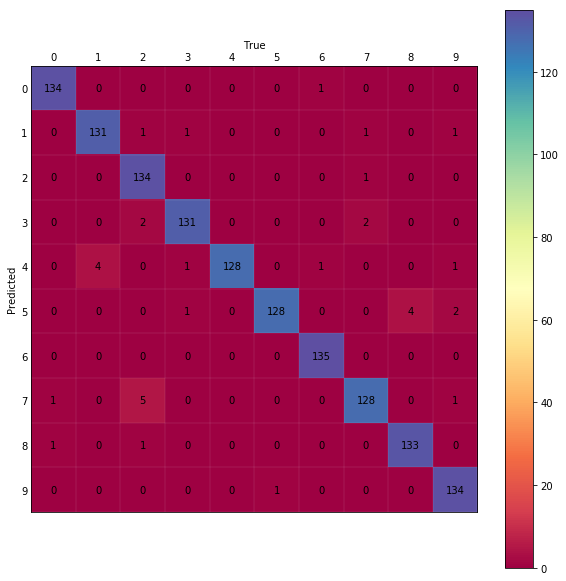

In [27]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_valid, Y_predicted_valid, plot=True)

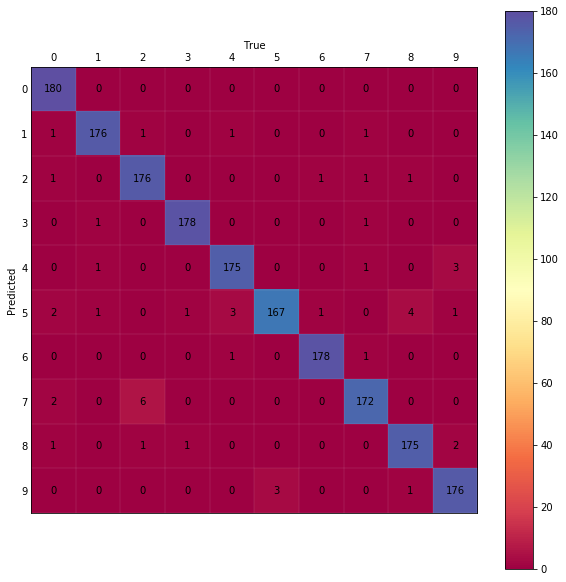

In [28]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_test, Y_predicted_test, plot=True)

# Backup Code
-----

In [11]:
from keras.models import load_model
mymodel.model = load_model("checkpoints/1523369406.7123575/naive_overfit_gru-30-0.97.hdf5")